# Universe creation and manipulation

Using MDAnalysis, RDKit, and OpenMM we will create an alpha helix from a sequence of amino acids. There are better tools to do that specific task, but it will make us use various interesting features of MDAnalysis.

In [1]:
import MDAnalysis as mda
import nglview as nv

_ColormakerRegistry()

In [2]:
from simtk import openmm, unit
from simtk.openmm import app
import pdbfixer

In [3]:
import rdkit

In [4]:
import numpy as np

## Creating a topology from a sequence using RDKit

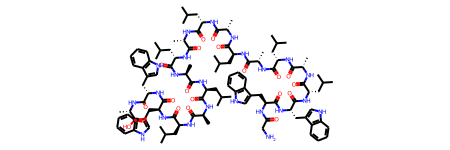

In [5]:
peptide = rdkit.Chem.MolFromSequence('GWWLALALALALALALWWA')
peptide

In [6]:
peptide.Compute2DCoords()

0

## Fix the backbone with MDAnalysis

At this point we have the correct topology, but the coordinates of the atoms are completely wrong.

### Loading the structure in MDAnalysis

MDAnalysis tries to be interoperable with as many tools as possible. Since version 2.0.0, it is possible to create a universe from an RDKit molecule, and vice versa.

Create a universe `u` from our RDKit peptive, then visualise the universe using NGLview.

In [7]:
u = mda.Universe(peptide)

In [8]:
v = nv.show_mdanalysis(u)
v.add_ball_and_stick()
v

c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:749: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'record_types' Using default value of 'ATOM'
  "".format(attrname, default))


NGLWidget()

### Finding the phi angles

To create an alpha helix, we need to set the phi, psi, and omega dihedral angles to -60°, -50°, and 180°, respectivelly. The phi angle for a given residue is defined by the atoms `C` of the previous residue, `N`, `CA`, and `C`. The psi angle is defined by the atoms `N`, `C`, `CA`, and `N` from the next residue. Omega is defined by atoms `CA` and `C` of the previous residue, `N`, and `CA`.

Before we can set the dihedral angles, we need to find them and get their current values. For each residue, create an atom group containing the 4 defining atoms of the phi angle.

In [9]:
u.residues.phi_selections()

[None,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>]

Calculate the angle in degrees for each phi angle.

In [10]:
[ag.dihedral.value() for ag in u.residues.phi_selections() if ag is not None]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 180.0,
 -180.0,
 0.0,
 0.0,
 0.0,
 180.0,
 180.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

### Rotating around a bond



### Building the helix

In [11]:
def set_dihedrals(ag, target_dihedral, dihedral_name):
    all_atoms = ag.universe.atoms
    
    for residue in ag.residues:
        if dihedral_name == 'phi':
            dihedral_selection = residue.phi_selection()
        elif dihedral_name == 'psi':
            dihedral_selection = residue.psi_selection()
        elif dihedral_name == 'omega':
            dihedral_selection = residue.omega_selection()
        else:
            raise ValueError(f'dihedral_name cannot be "{dihedral_name}"')

        if dihedral_selection is None:
            continue

        central_bond = dihedral_selection.intra_bonds[1]
        bond_vector = central_bond.atoms[1].position - central_bond.atoms[0].position
        center = central_bond.atoms[1].position

        mobile = all_atoms[central_bond.atoms[1].ix:] & ag
        
        dihedral = dihedral_selection.dihedral.value()
        dihedral_delta = target_dihedral - dihedral

        mobile.rotateby(dihedral_delta, bond_vector, center)

In [12]:
set_dihedrals(u.atoms, -60, 'phi')

In [13]:
set_dihedrals(u.atoms, -50, 'psi')

In [14]:
set_dihedrals(u.atoms, 180, 'omega')

In [15]:
v = nv.show_mdanalysis(u)
v.add_ball_and_stick()
v

NGLWidget()

## Fix the side chains with OpenMM

### Setting a box size

In [16]:
u.dimensions = [100, 100, 100, 90, 90, 90]

### Adding the hydrogen atoms

In [17]:
u.atoms.write('walp_broken.pdb')

In [18]:
fixer = pdbfixer.PDBFixer('walp_broken.pdb')

In [19]:
fixer.findMissingResidues()
fixer.findMissingAtoms()

In [20]:
fixer.missingAtoms

{}

In [21]:
fixer.addMissingHydrogens()

In [22]:
fixer.addMissingAtoms()

In [23]:
fixer.missingTerminals

{}

In [24]:
fixer.findNonstandardResidues()

In [25]:
fixer.nonstandardResidues

[]

In [26]:
fixer.replaceNonstandardResidues()

### Loading the structure with hydrogen atoms in MDAnalysis

In [27]:
q = fixer.positions.value_in_unit(unit.angstrom)

In [28]:
list(q[0])

[7.843999862670898, -8.059999942779541, 0.0]

In [29]:
a = mda.Universe(fixer.topology, np.array(q), topology_format='OPENMMTOPOLOGY')

In [30]:
a

<Universe with 309 atoms>

In [31]:
backbone = a.select_atoms('name N CA C')
backbone_id = backbone.ix
backbobe_pos = backbone.positions

In [32]:
backbone.names

array(['N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C',
       'N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C',
       'N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C',
       'N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C',
       'N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C'], dtype=object)

### Buiding the simulation for the energy minimisation

In [33]:
forcefield = app.ForceField('amber10.xml', 'amber10_obc.xml')

In [34]:
system = forcefield.createSystem(fixer.topology)

In [35]:
force = openmm.CustomExternalForce('k * periodicdistance(x, y, z, x0, y0, z0)^2')
force.addGlobalParameter('k', 1e5 * unit.kilocalorie_per_mole / unit.nanometer ** 2)
force.addPerParticleParameter('x0')
force.addPerParticleParameter('y0')
force.addPerParticleParameter('z0')

for atom in backbone:
    position = [pos / 10 for pos in atom.position]
    force.addParticle(int(atom.ix), position)

In [36]:
system.addForce(force)

6

In [37]:
integrator = openmm.LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtosecond)

In [38]:
simulation = app.Simulation(fixer.topology, system, integrator)

In [39]:
simulation.context.getState().getPeriodicBoxVectors()

Quantity(value=[Vec3(x=10.0, y=0.0, z=0.0), Vec3(x=0.0, y=10.0, z=0.0), Vec3(x=0.0, y=0.0, z=10.0)], unit=nanometer)

In [40]:
simulation.context.setPositions(fixer.positions)

In [41]:
simulation.minimizeEnergy()

## Check the final backbone with MDAnalysis

In [42]:
minimized = mda.Universe(simulation)

c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\base.py:873: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


In [43]:
v = nv.show_mdanalysis(minimized)
v.add_ball_and_stick()
v

c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget()

In [44]:
[ag.dihedral.value() for ag in minimized.residues.phi_selections() if ag is not None]

[-59.492220507734224,
 -60.36865323259409,
 -58.68129392560252,
 -59.26391457277813,
 -61.11078533982478,
 -58.6628735923284,
 -59.35799157407433,
 -58.86658362418761,
 -61.01399940549937,
 -58.38069948697132,
 -59.79951127158953,
 -59.164112548113074,
 -61.076382175780886,
 -58.593848505071826,
 -62.689985060619804,
 -59.79354020396948,
 -62.00291144652154,
 -60.620870911498464]

In [45]:
[ag.dihedral.value() for ag in minimized.residues.psi_selections() if ag is not None]

[-51.555597858910645,
 -51.387671881706126,
 -50.20910283717849,
 -55.43582778337577,
 -50.77139265256178,
 -53.99281530648902,
 -51.00621673401099,
 -54.60458027560704,
 -50.81309219954772,
 -53.89285894478256,
 -50.983358292454646,
 -54.41553220856698,
 -50.23137939576318,
 -53.86027979626206,
 -50.67159948532674,
 -51.19996069033115,
 -49.40124500818488,
 -50.04375245446344]

In [46]:
[ag.dihedral.value() for ag in minimized.residues.omega_selections() if ag is not None]

[-179.09017084670757,
 -179.9805511738878,
 179.9561825839601,
 -178.44132769853996,
 -179.01594098560065,
 -178.5223353712873,
 -179.7523365905133,
 -178.6857342141093,
 -179.35116647163497,
 -178.70508828287615,
 -179.6648320236203,
 -178.64227741313428,
 -179.7972128260878,
 -178.6489635149483,
 -179.20789711105743,
 -179.6836603475026,
 179.59541444197853,
 -179.83681754484314]